1. Cargar y explorar la base de datos de cabildos

    Objetivo: Revisar qué columnas tienes (probablemente concepto, fundamento, region, etc.) y filtrar solo los registros relevantes.

In [13]:
import pandas as pd

df = pd.read_excel(r"C:\Entorno_Desarrollo\UDD\Procesamiento_NPL\Procesamiento-LN\Lab1_NLP\data\resultadocabildoprovincial.xlsx", sheet_name='registros')
df.head()

df['concepto_nombre'].value_counts()

concepto_nombre
Otro                                7121
Igualdad                             649
Justicia                             619
A la salud                           614
A la educación                       611
                                    ... 
De petición ante las autoridades       2
Reunión pacífica                       2
Emprendimiento libre                   1
Libertad ambulatoria                   1
Patriotismo                            1
Name: count, Length: 113, dtype: int64

2. Preprocesamiento de texto

    Objetivo: Limpiar los textos para crear tokens listos para análisis.

    Pasos clave:

    Convertir a minúsculas.

    Eliminar puntuación, stopwords, tildes y caracteres especiales.

    Tokenizar con nltk o spaCy (te recomiendo spaCy, por las etiquetas gramaticales POS).

    Filtrar por tipo de palabra (por ejemplo, sustantivos).

In [14]:
import spacy
nlp = spacy.load("es_core_news_sm")

def preprocesar_texto(texto):
    doc = nlp(texto.lower())
    tokens = [token.lemma_ for token in doc 
                if token.is_alpha and not token.is_stop]
    return tokens

df['tokens'] = df['fundamento'].apply(preprocesar_texto)


3. WordCloud con sustantivos

    Extraer solo las palabras con etiqueta NOUN.

Luego generar el WordCloud con Counter:

In [19]:
# Verificar el contenido del dataframe
print("Columnas disponibles:", df.columns.tolist())
print("\nPrimeras filas de 'fundamento':")
print(df['fundamento'].head(3))
print("\nTipo de datos de 'fundamento':")
print(df['fundamento'].dtype)
print("\nValores nulos en 'fundamento':")
print(df['fundamento'].isnull().sum())

Columnas disponibles: ['region_nombre', 'provincia_nombre', 'comuna_nombre', 'cabildo_id', 'cabildo_nombre', 'cabildo_direccion', 'num_mesa', 'pregunta_glosa', 'concepto_nombre', 'concepto_otro', 'tipo-eleccion', 'fundamento', 'tokens']

Primeras filas de 'fundamento':
0                                       sin fundamento
1                                       Sin fundamento
2    La descentralizacion de ser autonoma por ser z...
Name: fundamento, dtype: object

Tipo de datos de 'fundamento':
object

Valores nulos en 'fundamento':
0


In [20]:
def bigramas_sust_adj(texto):
    """
    Función mejorada para extraer bigramas de sustantivos y adjetivos
    """
    # Verificar que el texto no esté vacío o sea solo "sin fundamento"
    if pd.isna(texto) or texto.lower().strip() in ['sin fundamento', 'nan', '']:
        return []
    
    doc = nlp(str(texto).lower())
    
    # Extraer solo sustantivos y adjetivos no stopwords
    tokens_relevantes = [token.lemma_ for token in doc 
                        if (token.pos_ in ["NOUN", "ADJ"]) and 
                           token.is_alpha and 
                           not token.is_stop and 
                           len(token.lemma_) > 2]
    
    # Crear bigramas (pares de palabras consecutivas)
    bigramas = []
    for i in range(len(tokens_relevantes) - 1):
        bigrama = f"{tokens_relevantes[i]} {tokens_relevantes[i+1]}"
        bigramas.append(bigrama)
    
    return bigramas

# Probar con un texto que tenga contenido real
textos_ejemplo = df[~df['fundamento'].str.contains('sin fundamento', case=False, na=False)]['fundamento'].head(3)
print("Textos de ejemplo (que no son 'sin fundamento'):")
for i, texto in enumerate(textos_ejemplo):
    print(f"\n{i+1}. {texto[:100]}...")
    bigramas = bigramas_sust_adj(texto)
    print(f"   Bigramas extraídos: {bigramas[:5]}")  # Primeros 5 bigramas

Textos de ejemplo (que no son 'sin fundamento'):

1. La descentralizacion de ser autonoma por ser zona extrema del pais...
   Bigramas extraídos: ['descentralizacion zona', 'zona extremo', 'extremo pais']

2. Sin furdamento...
   Bigramas extraídos: []

3. Sin furdamento...
   Bigramas extraídos: []


Extrayendo bigramas de todos los textos...
Total de bigramas extraídos: 88563
Bigramas únicos: 50963

Bigramas más frecuentes:
  acta fundamento: 335
  recurso natural: 281
  derechos humanos: 245
  pueblo originario: 212
  derecho vida: 208
  derecho fundamental: 200
  derecho deber: 183
  campo vacío: 175
  gratuito calidad: 169
  participación ciudadano: 158
Total de bigramas extraídos: 88563
Bigramas únicos: 50963

Bigramas más frecuentes:
  acta fundamento: 335
  recurso natural: 281
  derechos humanos: 245
  pueblo originario: 212
  derecho vida: 208
  derecho fundamental: 200
  derecho deber: 183
  campo vacío: 175
  gratuito calidad: 169
  participación ciudadano: 158


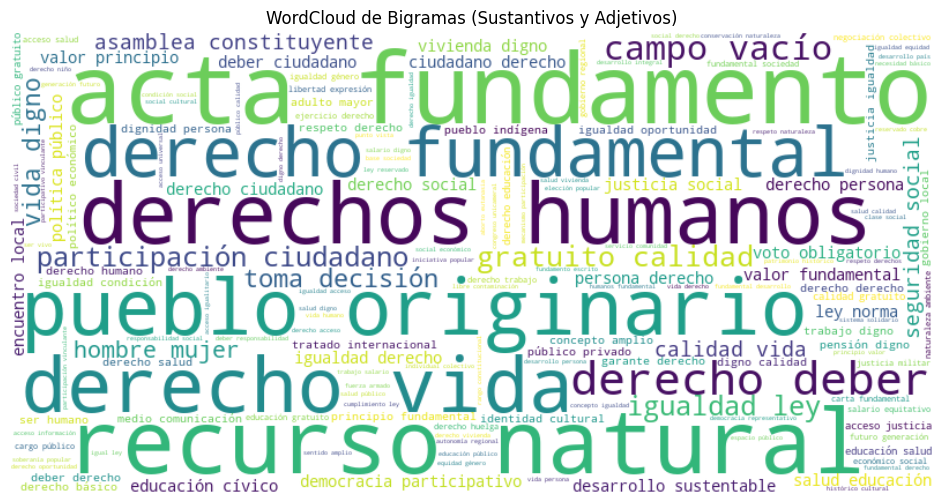

In [21]:
from collections import Counter

# Extraer todos los bigramas de sustantivos y adjetivos del dataframe
print("Extrayendo bigramas de todos los textos...")
bigramas = sum(df['fundamento'].apply(bigramas_sust_adj), [])

print(f"Total de bigramas extraídos: {len(bigramas)}")
print(f"Bigramas únicos: {len(set(bigramas))}")

# Mostrar los bigramas más frecuentes
contador_bigramas = Counter(bigramas)
print("\nBigramas más frecuentes:")
for bigrama, freq in contador_bigramas.most_common(10):
    print(f"  {bigrama}: {freq}")

# Generar WordCloud solo si hay bigramas
if bigramas:
    wc_bigramas = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(contador_bigramas)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc_bigramas, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud de Bigramas (Sustantivos y Adjetivos)')
    plt.show()
else:
    print("No se encontraron bigramas para generar el WordCloud")